In [24]:
# Import necessary libraries
import torch
import numpy as np
from scipy.io import loadmat
from torch_geometric.data import Data, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.nn import Sequential, Linear
from torch_geometric.nn import NNConv
import torch.nn.functional as F
from tqdm import tqdm
import utm


In [25]:
# %% Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cuda


In [26]:

def signal_strength_to_distance(P_r_dBm, P_t_dBm=13.01, G_t_dBi=0, G_r_dBi=0, f_MHz=915):
    """
    Convert received signal strength (in dBm) to distance (in meters) using the Friis equation.
    """
    # Constants
    constant = 32.44  # Free-space path loss constant in dB for distances in km and frequency in MHz
    
    # Calculate path loss (in dB)
    path_loss_dB = P_t_dBm + G_t_dBi + G_r_dBi - P_r_dBm
    
    # Calculate distance in kilometers
    exponent = (path_loss_dB - 20 * np.log10(f_MHz) - constant) / 20
    distance_km = 10 ** exponent
    
    # Convert distance to meters
    distance_m = distance_km * 1000
    return distance_m


In [27]:
# %% Load data from MATLAB files
num_instances = 1000
data_list = []

for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"matlab/data/small_4beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    # Extract positions and signal strength
    node_latitudes = mat_data['nodeLatitudes'].flatten()
    node_longitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']


    # Convert lat/lon to UTM coordinates
    utm_coords = [utm.from_latlon(lat, lon)[:2] for lat, lon in zip(node_latitudes, node_longitudes)]
    utm_coords = np.array(utm_coords)  # Shape: (num_nodes, 2)

    # Number of nodes
    num_nodes = len(node_latitudes)

    # Create truth locations (latitude and longitude converted to x, y coordinates)
    # truth_location_list = np.column_stack((node_latitudes, node_longitudes))
    # Truth locations in UTM coordinates
    truth_location_list = utm_coords  # Shape: (num_nodes, 2)


    # Compute distances and create edge attributes
    edge_index_list = []
    edge_attr_list = []

    # for i in range(num_nodes):
    #     for j in range(num_nodes):
    #         if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
    #             edge_index_list.append([i, j])
    #             edge_attr_list.append(signal_strength_matrix[i, j, :])  # Use all 10 simulated measurements
    
    # edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    # edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # Extract signal strengths for this edge
                ss_values = signal_strength_matrix[i, j, :]  # Shape: (num_measurements,)
                # Convert signal strengths to distances
                distances = signal_strength_to_distance(ss_values)
                edge_attr_list.append(distances)
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)  # Shape: (num_edges, num_measurements)

    # Create node features
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:1] = True  # First 1 nodes are anchors
    unknown_mask = ~anchor_mask

    # Node features: coordinates and anchor flag (1 for anchor, 0 for unknown)
    node_features = []
    # for i in range(num_nodes):
    #     is_anchor = 1 if i < 1 else 0
    #     node_features.append([node_latitudes[i], node_longitudes[i], is_anchor])

    # Node features: coordinates (anchors only) and anchor flag (1 for anchor, 0 for unknown)
    # for i in range(num_nodes):
    #     is_anchor = 1 if i < 4 else 0  # Adjust if your anchors are not the first 4 nodes
    #     if is_anchor:
    #         node_features.append([node_latitudes[i], node_longitudes[i], is_anchor])
    #     else:
    #         # Initialize unknown nodes' positions with zeros
    #         node_features.append([0.0, 0.0, is_anchor])

    for i in range(num_nodes):
        is_anchor = 1 if i < 1 else 0  # Adjust based on your number of anchors
        if is_anchor:
            # Anchors: Use known positions and an anchor flag
            node_features.append([utm_coords[i][0], utm_coords[i][1], is_anchor])
        else:
            # Unknown nodes: Initialize positions with zeros or estimates
            node_features.append([0.0, 0.0, is_anchor])


    x = torch.tensor(node_features, dtype=torch.float)

    # Labels (ground truth positions)
    y = torch.tensor(truth_location_list, dtype=torch.float)
    
    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    data_list.append(data)

Loading MATLAB data: 100%|██████████| 1000/1000 [00:00<00:00, 1049.98it/s]


In [28]:
# # %% Normalize features using StandardScaler
# all_features = torch.cat([data.x for data in data_list], dim=0).numpy()
# scaler = StandardScaler()
# scaler.fit(all_features)

# for data in data_list:
#     data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)
# Collect features from anchor nodes only for fitting the scaler
# all_anchor_features = torch.cat([data.x[data.anchor_mask] for data in data_list], dim=0).numpy()
# scaler = StandardScaler()
# scaler.fit(all_anchor_features)

# # Apply the scaler to all data
# for data in data_list:
#     data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)

all_features = torch.cat([data.x for data in data_list], dim=0).numpy()
scaler = StandardScaler()
scaler.fit(all_features)

for data in data_list:
    data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)

# %% Create DataLoader
train_loader = DataLoader(data_list, batch_size=2, shuffle=True)

C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [29]:
# %% Define GCN model
class EdgeFeatureNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EdgeFeatureNet, self).__init__()
        self.net = Sequential(
            Linear(input_dim, 64),
            torch.nn.ReLU(),
            Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, edge_feature_dim, num_measurements):
        super(GCN, self).__init__()
        # Edge feature network to process time-series edge attributes
        self.edge_net = EdgeFeatureNet(num_measurements, edge_feature_dim)
        
        # Edge networks for NNConv layers
        nn1 = Sequential(Linear(edge_feature_dim, hidden_dim * input_dim))
        self.conv1 = NNConv(input_dim, hidden_dim, nn1, aggr='mean')
        
        nn2 = Sequential(Linear(edge_feature_dim, hidden_dim * hidden_dim))
        self.conv2 = NNConv(hidden_dim, hidden_dim, nn2, aggr='mean')
        
        self.fc = Linear(hidden_dim, output_dim)
        
        # Projection layers for anchor nodes
        self.anchor_proj1 = Linear(input_dim, hidden_dim)
        self.anchor_proj2 = Linear(hidden_dim, hidden_dim)
    
    def forward(self, x, edge_index, edge_attr, anchor_mask):
        # Process edge attributes using EdgeFeatureNet
        edge_attr_processed = self.edge_net(edge_attr)
        
        # Save the original features of anchor nodes
        x_anchor = x[anchor_mask]
        
        # First GNN layer
        x = self.conv1(x, edge_index, edge_attr_processed)
        x = F.relu(x)
        
        # Project anchor nodes' features to match the hidden dimension
        x_anchor_proj = self.anchor_proj1(x_anchor)
        
        # Create a full-sized tensor for x_anchor_proj
        x_anchor_proj_full = x.clone()
        x_anchor_proj_full[anchor_mask] = x_anchor_proj
        
        # Combine the projected anchor features with the updated features
        x = torch.where(anchor_mask.unsqueeze(1), x_anchor_proj_full, x)
        
        # Save the features of anchor nodes after the first layer
        x_anchor = x[anchor_mask]
        
        # Second GNN layer
        x = self.conv2(x, edge_index, edge_attr_processed)
        x = F.relu(x)
        
        # Project anchor nodes' features to match the hidden dimension
        x_anchor_proj = self.anchor_proj2(x_anchor)
        
        # Create a full-sized tensor for x_anchor_proj
        x_anchor_proj_full = x.clone()
        x_anchor_proj_full[anchor_mask] = x_anchor_proj
        
        # Combine the anchor features with the updated features
        x = torch.where(anchor_mask.unsqueeze(1), x_anchor_proj_full, x)
        
        # Final fully connected layer
        x = self.fc(x)
        return x

In [30]:
# %% Instantiate model and optimizer
input_dim = data_list[0].x.shape[1]  # Adjust input dimension based on node features
hidden_dim = 64  # Adjust as needed
output_dim = 2   # Predicting x and y coordinates
edge_feature_dim = 32  # Adjust as needed

model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, edge_feature_dim=edge_feature_dim, num_measurements=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)


In [31]:
# %% Training loop
model.train()
loss_history = []

for epoch in range(50):
    total_loss = 0

    for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)

        # Compute loss only for unknown nodes
        loss = F.mse_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

Training Epoch 1: 100%|██████████| 500/500 [00:03<00:00, 127.56it/s]


Epoch 1, Loss: 6128226161037876224.0000


Training Epoch 2: 100%|██████████| 500/500 [00:03<00:00, 139.43it/s]


Epoch 2, Loss: 782304756482935040.0000


Training Epoch 3: 100%|██████████| 500/500 [00:03<00:00, 141.95it/s]


Epoch 3, Loss: 752566559658381184.0000


Training Epoch 4: 100%|██████████| 500/500 [00:03<00:00, 139.78it/s]


Epoch 4, Loss: 205631245743177088.0000


Training Epoch 5: 100%|██████████| 500/500 [00:03<00:00, 137.78it/s]


Epoch 5, Loss: 79916509166583152.0000


Training Epoch 6: 100%|██████████| 500/500 [00:03<00:00, 140.58it/s]


Epoch 6, Loss: 77590435910909.9531


Training Epoch 7: 100%|██████████| 500/500 [00:03<00:00, 139.36it/s]


Epoch 7, Loss: 833270999343105536.0000


Training Epoch 8: 100%|██████████| 500/500 [00:03<00:00, 139.59it/s]


Epoch 8, Loss: 3581009121001865.0000


Training Epoch 9: 100%|██████████| 500/500 [00:03<00:00, 137.99it/s]


Epoch 9, Loss: 8301015469725319.0000


Training Epoch 10: 100%|██████████| 500/500 [00:03<00:00, 138.57it/s]


Epoch 10, Loss: 136830036605927.4219


Training Epoch 11: 100%|██████████| 500/500 [00:03<00:00, 139.75it/s]


Epoch 11, Loss: 138208819318620.1562


Training Epoch 12: 100%|██████████| 500/500 [00:03<00:00, 141.61it/s]


Epoch 12, Loss: 5847528415679218.0000


Training Epoch 13: 100%|██████████| 500/500 [00:03<00:00, 139.76it/s]


Epoch 13, Loss: 273575901934937696.0000


Training Epoch 14: 100%|██████████| 500/500 [00:03<00:00, 140.27it/s]


Epoch 14, Loss: 1660764615867367.5000


Training Epoch 15: 100%|██████████| 500/500 [00:03<00:00, 140.21it/s]


Epoch 15, Loss: 23648370948046.8477


Training Epoch 16: 100%|██████████| 500/500 [00:03<00:00, 139.21it/s]


Epoch 16, Loss: 122790585171968.0000


Training Epoch 17: 100%|██████████| 500/500 [00:03<00:00, 137.46it/s]


Epoch 17, Loss: 41288903450165.2500


Training Epoch 18: 100%|██████████| 500/500 [00:03<00:00, 135.12it/s]


Epoch 18, Loss: 563366901381803776.0000


Training Epoch 19: 100%|██████████| 500/500 [00:03<00:00, 137.08it/s]


Epoch 19, Loss: 12890417531396816.0000


Training Epoch 20: 100%|██████████| 500/500 [00:03<00:00, 140.45it/s]


Epoch 20, Loss: 1861972773235064.7500


Training Epoch 21: 100%|██████████| 500/500 [00:03<00:00, 140.44it/s]


Epoch 21, Loss: 1354467749873582.0000


Training Epoch 22: 100%|██████████| 500/500 [00:03<00:00, 135.94it/s]


Epoch 22, Loss: 25925261978723420.0000


Training Epoch 23: 100%|██████████| 500/500 [00:03<00:00, 135.89it/s]


Epoch 23, Loss: 17824519049133948.0000


Training Epoch 24: 100%|██████████| 500/500 [00:03<00:00, 139.22it/s]


Epoch 24, Loss: 30638707359600344.0000


Training Epoch 25: 100%|██████████| 500/500 [00:03<00:00, 138.52it/s]


Epoch 25, Loss: 176839374402486.2812


Training Epoch 26: 100%|██████████| 500/500 [00:03<00:00, 142.68it/s]


Epoch 26, Loss: 16504895615771082.0000


Training Epoch 27: 100%|██████████| 500/500 [00:03<00:00, 141.55it/s]


Epoch 27, Loss: 3388082498183364.5000


Training Epoch 28: 100%|██████████| 500/500 [00:03<00:00, 141.59it/s]


Epoch 28, Loss: 33138778630207308.0000


Training Epoch 29: 100%|██████████| 500/500 [00:03<00:00, 143.23it/s]


Epoch 29, Loss: 236924464417210.3750


Training Epoch 30: 100%|██████████| 500/500 [00:03<00:00, 137.69it/s]


Epoch 30, Loss: 11874422222254768.0000


Training Epoch 31: 100%|██████████| 500/500 [00:03<00:00, 138.85it/s]


Epoch 31, Loss: 10763189957214340.0000


Training Epoch 32: 100%|██████████| 500/500 [00:03<00:00, 141.62it/s]


Epoch 32, Loss: 15319271497690776.0000


Training Epoch 33: 100%|██████████| 500/500 [00:03<00:00, 140.34it/s]


Epoch 33, Loss: 10574172452656514.0000


Training Epoch 34: 100%|██████████| 500/500 [00:03<00:00, 141.39it/s]


Epoch 34, Loss: 38029409013392736.0000


Training Epoch 35: 100%|██████████| 500/500 [00:03<00:00, 140.99it/s]


Epoch 35, Loss: 32415505460539424.0000


Training Epoch 36: 100%|██████████| 500/500 [00:03<00:00, 140.55it/s]


Epoch 36, Loss: 83925000072986.6250


Training Epoch 37: 100%|██████████| 500/500 [00:03<00:00, 141.97it/s]


Epoch 37, Loss: 223525330489442.3125


Training Epoch 38: 100%|██████████| 500/500 [00:03<00:00, 137.09it/s]


Epoch 38, Loss: 104925366945054.7188


Training Epoch 39: 100%|██████████| 500/500 [00:03<00:00, 135.84it/s]


Epoch 39, Loss: 9145327738181124.0000


Training Epoch 40: 100%|██████████| 500/500 [00:03<00:00, 137.79it/s]


Epoch 40, Loss: 58105534889180792.0000


Training Epoch 41: 100%|██████████| 500/500 [00:03<00:00, 141.82it/s]


Epoch 41, Loss: 28778284887320820.0000


Training Epoch 42: 100%|██████████| 500/500 [00:03<00:00, 141.91it/s]


Epoch 42, Loss: 298928397667532.8125


Training Epoch 43: 100%|██████████| 500/500 [00:03<00:00, 164.28it/s]


Epoch 43, Loss: 102910966763618.2969


Training Epoch 44: 100%|██████████| 500/500 [00:02<00:00, 198.66it/s]


Epoch 44, Loss: 2026396902062293.0000


Training Epoch 45: 100%|██████████| 500/500 [00:02<00:00, 190.31it/s]


Epoch 45, Loss: 25008467297843544.0000


Training Epoch 46: 100%|██████████| 500/500 [00:02<00:00, 192.17it/s]


Epoch 46, Loss: 154622964556365.8125


Training Epoch 47: 100%|██████████| 500/500 [00:02<00:00, 190.88it/s]


Epoch 47, Loss: 13387282825871.3594


Training Epoch 48: 100%|██████████| 500/500 [00:02<00:00, 183.86it/s]


Epoch 48, Loss: 16751873935540.2246


Training Epoch 49: 100%|██████████| 500/500 [00:02<00:00, 172.04it/s]


Epoch 49, Loss: 404045056670957.5625


Training Epoch 50: 100%|██████████| 500/500 [00:02<00:00, 191.20it/s]

Epoch 50, Loss: 16340437374756454.0000


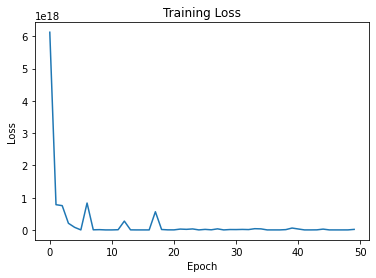

In [32]:
# %% Plot training loss
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [33]:
# %% Evaluation and Visualization of GCN Results
from geopy.distance import geodesic

model.eval()
errors_gcn = []

# Create test DataLoader
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing GCN"):
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)
        predicted_positions = out.cpu().numpy()
        true_positions = data.y.cpu().numpy()

        # Overwrite anchor nodes' positions with true positions (since anchors are known)
        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        # Calculate estimation errors for unknown nodes using Haversine distance
        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:  # Only for unknown nodes
                true_pos = (true_positions[idx][0], true_positions[idx][1])
                pred_pos = (predicted_positions[idx][0], predicted_positions[idx][1])
                error = geodesic(true_pos, pred_pos).meters
                errors_gcn.append(error)

# %% Convert errors to numpy arrays
errors_gcn = np.array(errors_gcn)

# Plot error distributions
plt.figure(figsize=(12, 6), facecolor='white')

plt.hist(errors_gcn, bins=20, alpha=0.7, label='GCN Errors', color='skyblue')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

# Print mean and median errors
print(f"GCN Mean Error: {errors_gcn.mean():.4f} meters, Median Error: {np.median(errors_gcn):.4f} meters")

# %% Visualization: Ground Truth vs. Predicted Positions
sample_data = data_list[0]  # Get a sample test graph for visualization
sample_data = sample_data.to(device)

with torch.no_grad():
    out = model(sample_data.x, sample_data.edge_index, sample_data.edge_attr, sample_data.anchor_mask)
    predicted_positions = out.cpu().numpy()
    true_positions = sample_data.y.cpu().numpy()

# Overwrite anchor nodes' positions with true positions (since anchors are known)
predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

# Plotting
plt.figure(figsize=(12, 6), facecolor='white')

# Ground truth positions
plt.scatter(true_positions[sample_data.unknown_mask.cpu(), 0], true_positions[sample_data.unknown_mask.cpu(), 1], 
            c='blue', label='True Unknown Node Positions', alpha=0.6)

# Predicted positions
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(), 0], predicted_positions[sample_data.unknown_mask.cpu(), 1], 
            c='red', label='Predicted Unknown Node Positions (GCN)', alpha=0.6)

# Anchor positions
plt.scatter(true_positions[sample_data.anchor_mask.cpu(), 0], true_positions[sample_data.anchor_mask.cpu(), 1], 
            c='green', label='Anchor Nodes', marker='^', s=100)

plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Comparison of True vs. Predicted Node Positions')
plt.grid(True)
plt.show()


Testing GCN:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)
Testing GCN:   0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: Latitude must be in the [-90; 90] range.

Testing GCN: 100%|██████████| 1000/1000 [00:03<00:00, 282.33it/s]


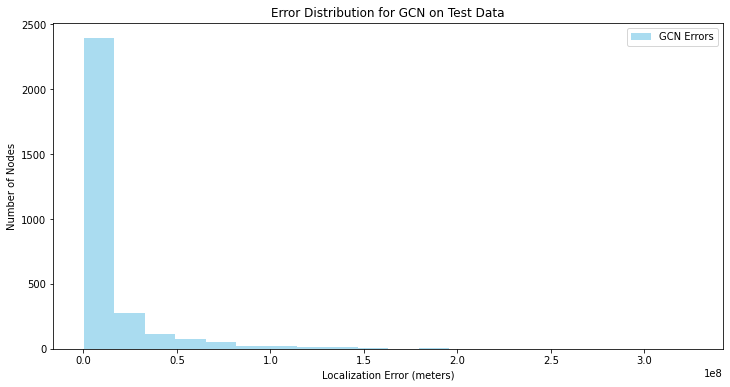

GCN Mean Error: 14827127.0000 meters, Median Error: 5148438.5000 meters


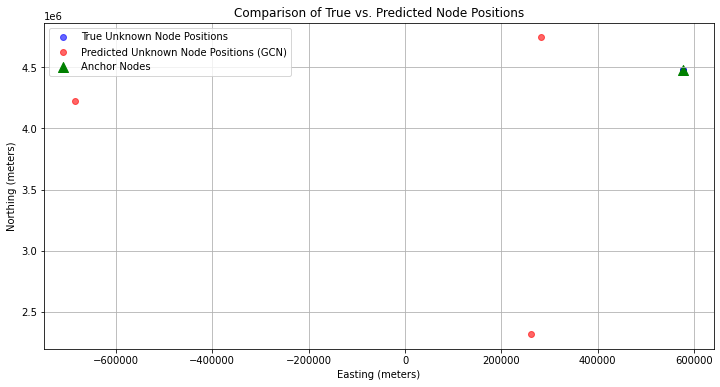

In [23]:
# %% Evaluation and Visualization of GCN Results
# Remove the geopy import since we won't use it
# from geopy.distance import geodesic

model.eval()
errors_gcn = []

# Create test DataLoader
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing GCN"):
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)
        predicted_positions = out.cpu().numpy()
        true_positions = data.y.cpu().numpy()

        # Overwrite anchor nodes' positions with true positions (since anchors are known)
        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        # Calculate estimation errors for unknown nodes using Euclidean distance
        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:  # Only for unknown nodes
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.linalg.norm(true_pos - pred_pos)
                errors_gcn.append(error)

# Convert errors to numpy arrays
errors_gcn = np.array(errors_gcn)

# Plot error distributions
plt.figure(figsize=(12, 6), facecolor='white')

plt.hist(errors_gcn, bins=20, alpha=0.7, label='GCN Errors', color='skyblue')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

# Print mean and median errors
print(f"GCN Mean Error: {errors_gcn.mean():.4f} meters, Median Error: {np.median(errors_gcn):.4f} meters")

# %% Visualization: Ground Truth vs. Predicted Positions
sample_data = data_list[0]  # Get a sample test graph for visualization
sample_data = sample_data.to(device)

with torch.no_grad():
    out = model(sample_data.x, sample_data.edge_index, sample_data.edge_attr, sample_data.anchor_mask)
    predicted_positions = out.cpu().numpy()
    true_positions = sample_data.y.cpu().numpy()

# Overwrite anchor nodes' positions with true positions (since anchors are known)
predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

# Plotting
plt.figure(figsize=(12, 6), facecolor='white')

# Ground truth positions
plt.scatter(true_positions[sample_data.unknown_mask.cpu(), 0], true_positions[sample_data.unknown_mask.cpu(), 1], 
            c='blue', label='True Unknown Node Positions', alpha=0.6)

# Predicted positions
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(), 0], predicted_positions[sample_data.unknown_mask.cpu(), 1], 
            c='red', label='Predicted Unknown Node Positions (GCN)', alpha=0.6)

# Anchor positions
plt.scatter(true_positions[sample_data.anchor_mask.cpu(), 0], true_positions[sample_data.anchor_mask.cpu(), 1], 
            c='green', label='Anchor Nodes', marker='^', s=100)

plt.legend()
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.title('Comparison of True vs. Predicted Node Positions')
plt.grid(True)
plt.show()
